# Analysis KEGG Gene Enrichment Databases of Humans and Mice 

Galen Seilis
2020-12-08

## Configuration

In [1]:
# Import Standard Libraries
from itertools import combinations

# Import External Libraries
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder

import networkx as nx
import numpy as np

import pandas as pd

from scipy.special import binom
from scipy.stats import pearsonr
from sklearn.decomposition import PCA

In [2]:
# Set library configurations
pd.set_option('display.max_columns', 20)
plt.rcParams['figure.figsize'] = [15,10]

In [3]:
# Define utility functions
def plot_weighted(G, fout='plotted_graph.pdf'):
    plt.style.use('dark_background')
    edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.log10(weights)
    max_weight = max(weights)
    nodes, degrees = zip(*nx.degree_centrality(G).items())

    pos = nx.spring_layout(G)
    nx.draw(G,
            pos,
            node_color=degrees,
            edgelist=edges,
            alpha=0.1,
            edge_color=weights,
            width=weights,
            edge_cmap=plt.cm.Blues,
            cmap=plt.cm.Oranges,
            node_size=np.array(degrees))
    plt.savefig(fout)
    plt.close()

def confusion_stats(C):
    '''
    This function takes in a 2x2 confusion matrix array-like
    data structre and constructs a dictionary of various
    confusion matrix statistics.

    ARGUMENTS
        C (array-like): 2x2 confusion matrix

    RETURNS
        stats (dict): A dictionary of confusion matrix statistics.

    Note to self: This function might be worth putting in a GitHub
    repository for future use. It is general enough that it could
    easily be used in future model evaluation projects.
    '''
    stats = {}
    stats['total_population'] = np.sum(C.flatten())
    stats['positive'] = np.sum(C[:,0])
    stats['negative'] = np.sum(C[:,1])
    stats['predicted_condition_positive'] = np.sum(C[0])
    stats['predicted_condition_negative'] = np.sum(C[1])
    stats['true_positive'] = C[0,0]
    stats['false_positive'] = C[0,1]
    stats['false_negative'] = C[1,0]
    stats['true_negative'] = C[1,1]
    stats['prevalence'] = stats['positive'] / stats['total_population']
    stats['accuracy'] = (stats['true_positive'] + stats['true_negative']) / stats['total_population']
    stats['precision'] = stats['true_positive'] / stats['predicted_condition_positive']
    stats['false_discovery_rate'] = stats['false_positive'] / stats['predicted_condition_positive']
    stats['false_omission_rate'] = stats['false_negative'] / stats['predicted_condition_negative']
    stats['negative_predictive_value'] = stats['true_negative'] / stats['predicted_condition_negative']
    stats['recall'] = stats['true_positive'] / stats['positive']
    stats['false_negative_rate'] = stats['false_negative'] / stats['positive']
    stats['false_positive_rate'] = stats['false_positive'] / stats['negative']
    stats['specificity'] = stats['true_negative'] / stats['negative']
    stats['positive_likelihood_ratio'] = stats['recall'] / stats['false_positive_rate']
    stats['negative_likelihood_ratio'] = stats['false_negative_rate'] / stats['specificity']
    stats['diagnotistic_odds_ratio'] = stats['positive_likelihood_ratio'] / stats['negative_likelihood_ratio']
    stats['f1_score'] = 2 * stats['precision'] * stats['recall'] / (stats['precision'] + stats['recall'])
    stats['prevalence_threshold'] = (np.sqrt(stats['recall'] * (-stats['specificity'] + 1)) +  stats['specificity'] - 1) / (stats['recall'] + stats['specificity'] - 1)
    stats['threat_score'] = stats['true_positive'] / (stats['true_positive'] + stats['false_negative'] + stats['false_positive'])
    stats['balanced_accuracy'] = (stats['recall'] + stats['specificity']) / 2
    num = stats['true_positive'] * stats['true_negative'] - stats['false_positive'] *  stats['false_negative']
    den = (stats['true_positive'] + stats['false_positive']) * (stats['true_positive'] + stats['false_negative']) * (stats['true_negative'] + stats['false_positive']) * (stats['true_negative'] + stats['false_negative'])
    stats['matthews_correlation_coefficient'] = num / np.sqrt(den)
    stats['fowlkes_mallows_index'] = np.sqrt(stats['precision'] * stats['recall'])
    stats['bookmaker_informedness'] = stats['recall'] + stats['specificity'] - 1
    stats['markedness'] = stats['precision'] + stats['negative_predictive_value'] - 1
    stats['fishers_exact_test_p'] = binom(stats['predicted_condition_positive'], stats['true_positive']) * binom(stats['predicted_condition_negative'], stats['false_negative']) / binom(stats['total_population'], stats['positive'])
    return stats


## Exploratory Data Analysis

### Frequent Pattern Mining and Association Rule Learning

In [4]:
# (Import data) AND (frequent pattern mining) AND (association rules mining)
'''
The following loop parses each data file into a pandas
dataframe, then it one-hot encodes the gene names, then
it finds the association rules, and then it writes those
frequent patterns and association rules into a file.

Note that the minimum support threshold for the pattern mining was
0.18 and the minimum confidence threshold for the rule mining.
'''
# Human dataset
file_human = 'KEGG_2019_Human.txt'
dict_human = {}
with open(file_human) as f:
    for line in f:
        dict_human[line.split('\t')[0]] = line.split('\t')[2:-1]
te_human = TransactionEncoder()
te_ary_human = te_human.fit(dict_human.values()).transform(dict_human.values())
df_human = df = pd.DataFrame(te_ary_human,
                             columns=te_human.columns_)
frequent_itemsets_human = fpgrowth(df_human,
                                   min_support=0.18,
                                   use_colnames=True)
frequent_itemsets_human.to_csv(f'FP_Human.csv',
                               index=False)
df_human['Biological_Process'] = dict_human.keys()
rules_human = association_rules(frequent_itemsets_human,
                                metric="confidence",
                                min_threshold=1.0)
rules_human.to_csv(f'AR_Human.csv', index=False)

del te_human, te_ary_human

# Mouse dataset
file_mouse = 'KEGG_2019_Mouse.txt'
dict_mouse = {}
with open(file_mouse) as f:
    for line in f:
        dict_mouse[line.split('\t')[0]] = line.split('\t')[2:-1]
te_mouse = TransactionEncoder()
te_ary_mouse = te_mouse.fit(dict_mouse.values()).transform(dict_mouse.values())
df_mouse = df = pd.DataFrame(te_ary_mouse,
                             columns=te_mouse.columns_)
frequent_itemsets_mouse = fpgrowth(df_mouse,
                                   min_support=0.18,
                                   use_colnames=True)
frequent_itemsets_mouse.to_csv(f'FP_Mouse.csv',
                               index=False)
df_mouse['Biological_Process'] = dict_mouse.keys()
rules_mouse = association_rules(frequent_itemsets_mouse,
                                metric="confidence",
                                min_threshold=1.0)
rules_mouse.to_csv(f'AR_Mouse.csv', index=False)

del te_mouse, te_ary_mouse

Text(0, 0.5, 'Consequent Support')

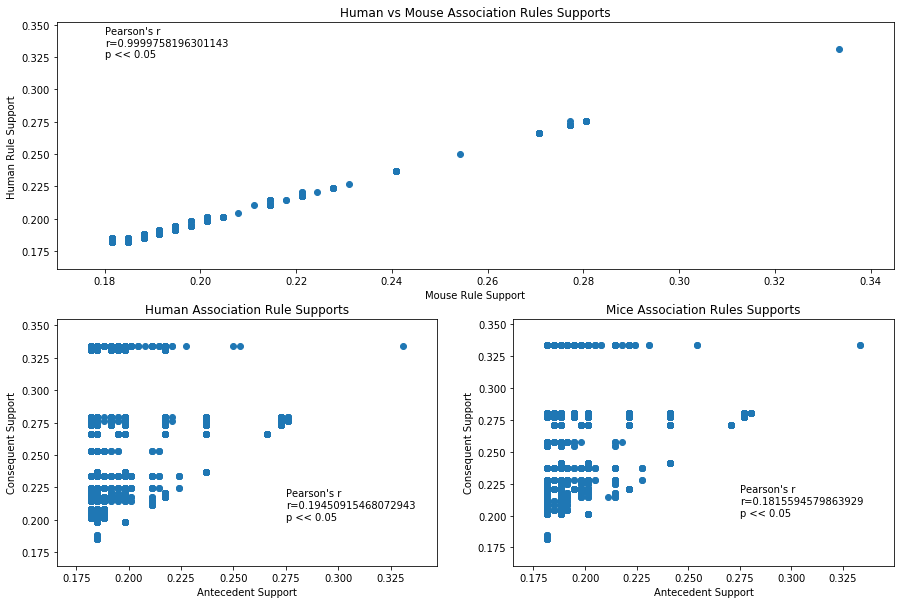

In [5]:
# Scatterplots of the support results
rules_both = pd.merge(rules_human, rules_mouse, on=['antecedents', 'consequents'])

plt.subplot(2,1,1)
plt.scatter(rules_both['support_y'], rules_both['support_x'])
r,p = pearsonr(rules_both['support_y'], rules_both['support_x'])
plt.text(0.18, 0.325, f'Pearson\'s r\nr={r}\np << 0.05')
plt.title('Human vs Mouse Association Rules Supports')
plt.xlabel('Mouse Rule Support')
plt.ylabel('Human Rule Support')

plt.subplot(2,2,3)
plt.scatter(rules_human['antecedent support'], rules_human['consequent support'])
r,p = pearsonr(rules_human['antecedent support'], rules_human['consequent support'])
plt.text(0.275, 0.2, f'Pearson\'s r\nr={r}\np << 0.05')
plt.title('Human Association Rule Supports')
plt.xlabel('Antecedent Support')
plt.ylabel('Consequent Support')

plt.subplot(2,2,4)
plt.scatter(rules_mouse['antecedent support'], rules_mouse['consequent support'])
r,p = pearsonr(rules_mouse['antecedent support'], rules_mouse['consequent support'])
plt.text(0.275, 0.2, f'Pearson\'s r\nr={r}\np << 0.05')
plt.title('Mice Association Rules Supports')
plt.xlabel('Antecedent Support')
plt.ylabel('Consequent Support')

In [6]:
# Confusion matrix between human rules and mouse rules
C = np.zeros((2,2))
C[0,1] = rules_mouse.shape[0] - rules_both.shape[0]
C[1,0] = rules_human.shape[0] - rules_both.shape[0]
C[0,0] = rules_both.shape[0]
d = len(set(df_human.keys()).union(set(df_mouse.keys()))) - 1
R = (3 ** d - 2 ** (d + 1) + 1) - (rules_mouse.shape[0] + rules_human.shape[0] - rules_both.shape[0])
try:
    '''
    Tried to set true negative to number
    of possible association rules not seen
    in either mouse or human rules.
    '''
    C[1,1] = R
except OverflowError:
    '''
    But instead set it to the largest
    allowed float value since the true
    value was too large.
    
    This implies certain boundaries
    rather than approximate values 
    for some of the entries in the
    following confusion matrix statistics.
    '''
    C[1,1] = np.finfo(C.dtype).max

# Print LaTeX rows for a tabular
max_stats = confusion_stats(C)
C[1,1] = 0
min_stats = confusion_stats(C)
print('\\begin{table}[H]\n\t\\begin{tabular}{lcc}')
for stat in max_stats.keys():
    print(f"\t\t{stat.title().replace('_', ' ')} & {round(min_stats[stat], 3)} & {round(max_stats[stat], 3)}" + ' \\\\')
print('\t\\end{tabular}\n\\end{table}')

\begin{table}[H]
	\begin{tabular}{lcc}
		Total Population & 204706.0 & inf \\
		Positive & 200205.0 & 200205.0 \\
		Negative & 4501.0 & inf \\
		Predicted Condition Positive & 204538.0 & 204538.0 \\
		Predicted Condition Negative & 168.0 & inf \\
		True Positive & 200037.0 & 200037.0 \\
		False Positive & 4501.0 & 4501.0 \\
		False Negative & 168.0 & 168.0 \\
		True Negative & 0.0 & inf \\
		Prevalence & 0.978 & 0.0 \\
		Accuracy & 0.977 & 1.0 \\
		Precision & 0.978 & 0.978 \\
		False Discovery Rate & 0.022 & 0.022 \\
		False Omission Rate & 1.0 & 0.0 \\
		Negative Predictive Value & 0.0 & 1.0 \\
		Recall & 0.999 & 0.999 \\
		False Negative Rate & 0.001 & 0.001 \\
		False Positive Rate & 1.0 & 0.0 \\
		Specificity & 0.0 & 1.0 \\
		Positive Likelihood Ratio & 0.999 & 3.990634567558178e+304 \\
		Negative Likelihood Ratio & inf & 0.001 \\
		Diagnotistic Odds Ratio & 0.0 & inf \\
		F1 Score & 0.988 & 0.988 \\
		Prevalence Threshold & 0.5 & 0.0 \\
		Threat Score & 0.977 & 0.977 \\
		Balance

/usr/lib/python3/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in multiply


In [7]:
# Find which biological processes are reliable for association rules inference
# between species

set_both = frozenset([i.union(j) for i,j in rules_both[['antecedents', 'consequents']].to_numpy()])
agree_dict = {i:0 for i in dict_human.keys()}
for k,v in dict_human.items():
    for rule_set in set_both:
        if rule_set.issubset(frozenset(v)):
            agree_dict[k] += 1

agree_dict = {i:j for i,j in agree_dict.items()}
agree_list = sorted(agree_dict.items(), key=lambda item: item[1], reverse=True)
agree_list = [(i.title(),j) for i,j in agree_list]
agree_dict = dict(agree_list)
print('\n'.join([f"\t\t{i[0]} & {i[1]}" + ' \\\\' for i in agree_list if i[1] > 4000]))


		Autophagy & 4496 \\
		Insulin Signaling Pathway & 4496 \\
		Pathways In Cancer & 4496 \\
		Ras Signaling Pathway & 4496 \\
		Relaxin Signaling Pathway & 4496 \\
		Apoptosis & 4495 \\
		Choline Metabolism In Cancer & 4495 \\
		Colorectal Cancer & 4495 \\
		Erbb Signaling Pathway & 4495 \\
		Fc Epsilon Ri Signaling Pathway & 4495 \\
		Foxo Signaling Pathway & 4495 \\
		Hepatitis B & 4495 \\
		Human Immunodeficiency Virus 1 Infection & 4495 \\
		Kaposi Sarcoma-Associated Herpesvirus Infection & 4495 \\
		Neurotrophin Signaling Pathway & 4495 \\
		Prolactin Signaling Pathway & 4495 \\
		Sphingolipid Signaling Pathway & 4495 \\
		Estrogen Signaling Pathway & 4492 \\
		Human Cytomegalovirus Infection & 4492 \\
		Human Papillomavirus Infection & 4492 \\
		Proteoglycans In Cancer & 4492 \\
		Thyroid Hormone Signaling Pathway & 4492 \\
		Acute Myeloid Leukemia & 4491 \\
		B Cell Receptor Signaling Pathway & 4491 \\
		Breast Cancer & 4491 \\
		Cellular Senescence & 4491 \\
		Central Carbon Met

Text(0, 0.5, 'Frequency')

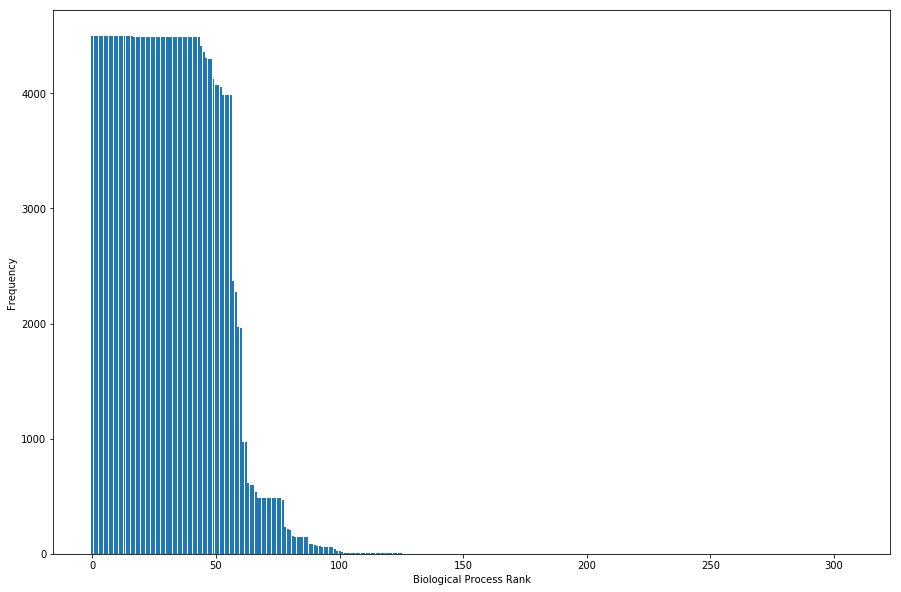

In [8]:
# Barplot of the rank order frequency of rule agreement between humans and mice
plt.bar(range(len(agree_dict)), agree_dict.values())
plt.xlabel('Biological Process Rank')
plt.ylabel('Frequency')

### Graph Visualizations

In [9]:
# See local script plot_weighted_graphs.py b/c drawing the networks was taking too much time
# Human graph
weighted_graph_human = nx.Graph()
for key, value in dict_human.items():
    for comb in combinations(value, r=2):
        if comb in weighted_graph_human.edges():
            weighted_graph_human[comb[0]][comb[1]]['weight'] += 1
        else:
            weighted_graph_human.add_edge(comb[0], comb[1], weight=1)

print(nx.info(weighted_graph_human).replace('Name:', 'Organism: Human'))
print(f'Density: {nx.density(weighted_graph_human)}')
plot_weighted(weighted_graph_human, 'weighted_graph_human.pdf')

# Mouse graph
weighted_graph_mouse = nx.Graph()
for key, value in dict_mouse.items():
    for comb in combinations(value, r=2):
        if comb in weighted_graph_mouse.edges():
            weighted_graph_mouse[comb[0]][comb[1]]['weight'] += 1
        else:
            weighted_graph_mouse.add_edge(comb[0], comb[1], weight=1)

print(nx.info(weighted_graph_mouse).replace('Name:', 'Organism: Mouse'))
print(f'Density: {nx.density(weighted_graph_mouse)}')
plot_weighted(weighted_graph_mouse, 'weighted_graph_mouse.pdf')

### Dimensionality Reduction (for visualization)

Text(0, 0.5, 'Principal Component 2')

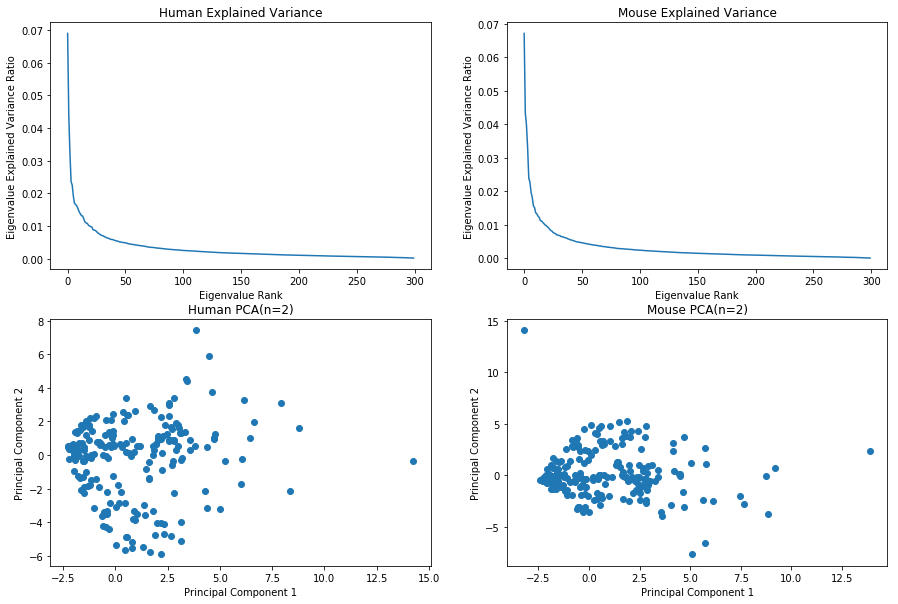

In [10]:
# Principal component analysis of one-hot representation of transactions
pca_human = PCA(n_components=2)
X_human = df_human[[key for key in df_human.keys() if key != 'Biological_Process']].to_numpy()
pca_human.fit(X_human)
trans_X_human = pca_human.transform(X_human)

pca_mouse = PCA(n_components=2)
X_mouse = df_mouse[[key for key in df_mouse.keys() if key != 'Biological_Process']].to_numpy()
pca_mouse.fit(X_mouse)
trans_X_mouse = pca_mouse.transform(X_mouse)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

ax1.plot(PCA(n_components=300).fit(X_human).explained_variance_ratio_)
ax1.title.set_text('Human Explained Variance')
ax1.set_xlabel('Eigenvalue Rank')
ax1.set_ylabel('Eigenvalue Explained Variance Ratio')

ax2.plot(PCA(n_components=300).fit(X_mouse).explained_variance_ratio_)
ax2.title.set_text('Mouse Explained Variance')
ax2.set_xlabel('Eigenvalue Rank')
ax2.set_ylabel('Eigenvalue Explained Variance Ratio')

ax3.scatter(trans_X_human[:, 0], trans_X_human[:, 1])
ax3.title.set_text('Human PCA(n=2)')
ax3.set_xlabel('Principal Component 1')
ax3.set_ylabel('Principal Component 2')

ax4.scatter(trans_X_mouse[:, 0], trans_X_mouse[:, 1])
ax4.title.set_text('Mouse PCA(n=2)')
ax4.set_xlabel('Principal Component 1')
ax4.set_ylabel('Principal Component 2')

In [23]:
len(str(R))

4747